<a href="https://colab.research.google.com/github/naokityokoyama/coursera/blob/main/Projeto_Final_coursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [96]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## collecting from neighborhoods using **beautifullsoup**

In [2]:
url = 'https://www.estadosecapitaisdobrasil.com/listas/lista-dos-bairros-do-rio-de-janeiro/'
html = requests.get(url)
soup = BeautifulSoup(html.text, 'lxml')

In [3]:
zonas = soup.find_all('h3')
lista_zonas = [x.get_text(strip=True) for x in zonas]
lista_zonas

['Zona Central', 'Zona Sul', 'Zona Oeste', 'Zona Norte']

In [5]:
#lista geral
geral = soup.find('article')

In [6]:
central  = geral.find('ul')
central_ = central.find_all('li')
lista_central = [x.get_text(strip=True) for x in central_]


In [7]:
zona_sul = central.find_next('ul')
zona_sul_ = zona_sul.find_all('li')
lista_zona_sul = [x.get_text(strip=True) for x in zona_sul_]

In [8]:
df = pd.DataFrame(lista_zona_sul, columns=['Bairro'])

## seeking latitude and longitude

In [9]:
#buscando latitude e longitude
lista_lat_long = []
for bairro in lista_zona_sul:
  dic = {}
  geolocator = Nominatim(user_agent="foursquare_agent")
  location = geolocator.geocode(bairro)
  latitude = location.latitude
  longitude = location.longitude
  dic['Latitude'] = latitude
  dic['Longitude'] = longitude
  lista_lat_long.append(dic)


In [10]:
df_ = pd.DataFrame(lista_lat_long)

In [11]:
df1 = pd.concat([df, df_], axis=1)

## correcting some coordinates

In [12]:
#coordenadas a serem corrigidas
humaita = [-22.9554346 ,-43.2109592]
urca = [-22.9480877, -43.1654148]    
lagoa = [-22.9694925, -43.2192887]
laranjeiras = [-22.9359414,-43.1974724]
leme = [-22.9618711,-43.1708805]

df1.loc[6,'Latitude']=humaita[0]
df1.loc[6,'Longitude']=humaita[1]

df1.loc[15,'Latitude']=urca[0]
df1.loc[15,'Longitude']=urca[1]

df1.loc[9,'Latitude']=lagoa[0]
df1.loc[9,'Longitude']=lagoa[1]

df1.loc[12,'Latitude']=leme[0]
df1.loc[12,'Longitude']=leme[1]

df1.loc[10,'Latitude']=laranjeiras[0]
df1.loc[10,'Longitude']=laranjeiras[1]

In [13]:
df1

,Bairro,Latitude,Longitude
0,Botafogo,-22.948845,-43.179829
1,Catete,-22.926920,-43.180219
2,Copacabana,-22.971964,-43.184343
3,Cosme Velho,-22.941514,-43.200624
4,Flamengo,-22.933984,-43.174574
5,Gávea,-22.981424,-43.238324
6,Humaitá,-22.955435,-43.210959
7,Ipanema,-22.983956,-43.202216
8,Jardim Botânico,-22.968385,-43.228694
9,Lagoa,-22.969493,-43.219289


In [14]:
#exportando do df1 para coletar dados com selenium
df1.to_csv('zona_sul.csv', index=False)

## neighborhoods on the map

In [13]:
#pontos de cada latitude e longitude
map_zona_sul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, bairro ,in zip(df1['Latitude'], df1['Longitude'], df1['Bairro']):
    label = f'{bairro}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_zona_sul)  
    
map_zona_sul

In [14]:
#credential
CLIENT_ID= 'HMR354NLXFDSLNDJNGKRN5BBCLWXHKM1FUPYZIGA1NWYB35E'
CLIENT_SECRET= 'GDKCYIOVO1CMRANJFIRI5WMBKELMHK3LKOYI2KRGBL3IZXOP'
VERSION = '20180604'
LIMIT = 30
search_query = 'sushi'
radius = 500
print(search_query + ' .... OK!')

sushi .... OK!


### Search function

In [15]:
#busca por Sushi na zona sul
def busca(nome):
  lista_url = []
  for lat, long in zip(df1['Latitude'], df1['Longitude']):
    radius = 1000
    search_query = nome
    CLIENT_ID= 'HMR354NLXFDSLNDJNGKRN5BBCLWXHKM1FUPYZIGA1NWYB35E'
    CLIENT_SECRET= 'GDKCYIOVO1CMRANJFIRI5WMBKELMHK3LKOYI2KRGBL3IZXOP'
    VERSION = '20180604'
    LIMIT = 30
    url=f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{long}&v={VERSION}&query={search_query}&radius={radius}&limit={LIMIT}'
    lista_url.append(url)
  return lista_url

In [16]:
#busca sushi
lista_results_sushi = []
for i in range(17):
  lista_results_sushi.append(requests.get(busca('sushi')[i]).json())

In [17]:
lista_results_2 = []
for x in range(17):
  lista_results_2.append(lista_results_sushi[x]['response']['venues'])

In [18]:
lista_final = []
for numero , bairro in zip(range(17), df1['Bairro']):
  for r in lista_results_2[numero]:
    dic_vazio = {"Bairro": [], "Restaurante": [], 'Lat_sushi':[], 'Long_sushi':[]}
    #print (r['name'])
    #dic_vazio[]
    dic_vazio['Bairro'] = bairro
    dic_vazio['Restaurante'] = r['name']
    dic_vazio['Lat_sushi'] = r['location']['lat']
    dic_vazio['Long_sushi'] = r['location']['lng']
    #dict_bairros[zonas[3]] = sub_norte # Zona Sul
    lista_final.append(dic_vazio)
    #print (r['location']['lng'])

In [19]:
df_sushi = pd.DataFrame(lista_final)

In [44]:
df_sushi

,Bairro,Restaurante,Lat_sushi,Long_sushi
0,Botafogo,Sushi Rio,-22.956909,-43.176396
1,Botafogo,Tsuru Sushi Culinária Japonesa e Sushi Bar,-22.953983,-43.186245
2,Botafogo,Sushi Japa Chan,-22.954249,-43.177712
3,Botafogo,Nakami Sushi Bar,-22.949723,-43.183260
4,Botafogo,Ai Sushi,-22.947087,-43.183544
...,...,...,...,...
110,Vidigal,Sushi Bar Rocinha,-22.991775,-43.251690
111,Vidigal,Sushi Yaki,-22.991844,-43.251355
112,Vidigal,99 Sushi Bar,-22.986477,-43.243163
113,Vidigal,Atelier Do Sushi,-22.990092,-43.251119


In [20]:
#pontos de cada sushi
map_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, su, bairro ,in zip(df_sushi['Lat_sushi'], df_sushi['Long_sushi'], df_sushi['Restaurante'], df_sushi['Bairro']):
    label = f'{su}, {bairro}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_sushi)  
    
map_sushi

starting dataset construction

In [21]:
df_ = pd.DataFrame(df_sushi['Bairro'].value_counts()).reset_index()
df_ = df_.rename(columns={'index':'Bairro', 'Bairro':'Numero_Sushi'})

In [23]:
df1

,Bairro,Latitude,Longitude
0,Botafogo,-22.948845,-43.179829
1,Catete,-22.926920,-43.180219
2,Copacabana,-22.971964,-43.184343
3,Cosme Velho,-22.941514,-43.200624
4,Flamengo,-22.933984,-43.174574
5,Gávea,-22.981424,-43.238324
6,Humaitá,-22.955435,-43.210959
7,Ipanema,-22.983956,-43.202216
8,Jardim Botânico,-22.968385,-43.228694
9,Lagoa,-22.969493,-43.219289


In [22]:
df2 = pd.merge(df1, df_, how='left' , on='Bairro')
df2

,Bairro,Latitude,Longitude,Numero_Sushi
0,Botafogo,-22.948845,-43.179829,9.0
1,Catete,-22.926920,-43.180219,8.0
2,Copacabana,-22.971964,-43.184343,17.0
3,Cosme Velho,-22.941514,-43.200624,1.0
4,Flamengo,-22.933984,-43.174574,7.0
5,Gávea,-22.981424,-43.238324,5.0
6,Humaitá,-22.955435,-43.210959,3.0
7,Ipanema,-22.983956,-43.202216,9.0
8,Jardim Botânico,-22.968385,-43.228694,5.0
9,Lagoa,-22.969493,-43.219289,6.0


In [23]:
#busca Academia 
lista_results_academia = []
for i in range(17):
  lista_results_academia.append(requests.get(busca('gym')[i]).json())

In [25]:
lista_results_academia_2 = []
for x in range(17):
  lista_results_academia_2.append(lista_results_academia[x]['response']['venues'])

In [26]:
lista_final_academia = []
for numero , bairro in zip(range(17), df1['Bairro']):
  for r in lista_results_academia_2[numero]:
    dic_vazio = {"Bairro": [], "Academia": []}
    #print (r['name'])
    #dic_vazio[]
    dic_vazio['Bairro'] = bairro
    dic_vazio['Academia'] = r['name']
    #dict_bairros[zonas[3]] = sub_norte # Zona Sul
    lista_final_academia.append(dic_vazio)

In [27]:
df_academia = pd.DataFrame(lista_final_academia)
df_academia = df_academia['Bairro'].value_counts()
df_academia = pd.DataFrame(df_academia).reset_index()
df_academia = df_academia.rename(columns={'index':'Bairro', 'Bairro':'Numero_Academia'})

In [28]:
df_academia

,Bairro,Numero_Academia
0,Botafogo,11
1,Copacabana,7
2,Leme,7
3,Flamengo,6
4,Gávea,4
5,Catete,4
6,Vidigal,4
7,Leblon,4
8,Lagoa,3
9,Urca,3


In [29]:
df3 = pd.merge(df2, df_academia, how='left', on='Bairro')

In [30]:
#df3 = df3.drop('Numero_Academia_y', axis=1)
df3 = df3.rename(columns={'Numero_Academia_x':'Numero_Academia'})

In [32]:
df3

,Bairro,Latitude,Longitude,Numero_Sushi,Numero_Academia
0,Botafogo,-22.948845,-43.179829,9.0,11.0
1,Catete,-22.926920,-43.180219,8.0,4.0
2,Copacabana,-22.971964,-43.184343,17.0,7.0
3,Cosme Velho,-22.941514,-43.200624,1.0,2.0
4,Flamengo,-22.933984,-43.174574,7.0,6.0
5,Gávea,-22.981424,-43.238324,5.0,4.0
6,Humaitá,-22.955435,-43.210959,3.0,1.0
7,Ipanema,-22.983956,-43.202216,9.0,3.0
8,Jardim Botânico,-22.968385,-43.228694,5.0,3.0
9,Lagoa,-22.969493,-43.219289,6.0,3.0


In [31]:
#busca Restaurante
lista_results_restaurante = []
for i in range(17):
  lista_results_restaurante.append(requests.get(busca('restaurante')[i]).json())

In [32]:
lista_results_restaurante_2 = []
for x in range(17):
  lista_results_restaurante_2.append(lista_results_restaurante[x]['response']['venues'])

In [33]:
lista_final_restaurante = []
for numero , bairro in zip(range(17), df1['Bairro']):
  for r in lista_results_restaurante_2[numero]:
    dic_vazio = {"Bairro": [], "Restaurante": []}
    #print (r['name'])
    #dic_vazio[]
    dic_vazio['Bairro'] = bairro
    dic_vazio['Restaurante'] = r['name']
    #dict_bairros[zonas[3]] = sub_norte # Zona Sul
    lista_final_restaurante.append(dic_vazio)

In [34]:
df_restaurantes = pd.DataFrame(lista_final_restaurante)

In [35]:
df_restaurante = df_restaurantes['Bairro'].value_counts().reset_index()
df_restaurante = df_restaurante.rename(columns={'index':'Bairro', 'Bairro':'Numero_Restaurante'})

In [36]:
df4 = pd.merge(df3, df_restaurante, how='left', on='Bairro')

In [38]:
df4

,Bairro,Latitude,Longitude,Numero_Sushi,Numero_Academia,Numero_Restaurante
0,Botafogo,-22.948845,-43.179829,9.0,11.0,30
1,Catete,-22.926920,-43.180219,8.0,4.0,30
2,Copacabana,-22.971964,-43.184343,17.0,7.0,30
3,Cosme Velho,-22.941514,-43.200624,1.0,2.0,5
4,Flamengo,-22.933984,-43.174574,7.0,6.0,30
5,Gávea,-22.981424,-43.238324,5.0,4.0,14
6,Humaitá,-22.955435,-43.210959,3.0,1.0,15
7,Ipanema,-22.983956,-43.202216,9.0,3.0,30
8,Jardim Botânico,-22.968385,-43.228694,5.0,3.0,21
9,Lagoa,-22.969493,-43.219289,6.0,3.0,24


In [37]:
#busca hotel
lista_results_hotel = []
for i in range(17):
  lista_results_hotel.append(requests.get(busca('hotel')[i]).json())

In [38]:
lista_results_hotel_2 = []
for x in range(17):
  lista_results_hotel_2.append(lista_results_hotel[x]['response']['venues'])

In [39]:
lista_final_hotel = []
for numero , bairro in zip(range(17), df1['Bairro']):
  for r in lista_results_hotel_2[numero]:
    dic_vazio = {"Bairro": [], "Hotel": []}
    #print (r['name'])
    #dic_vazio[]
    dic_vazio['Bairro'] = bairro
    dic_vazio['Hotel'] = r['name']
    #dict_bairros[zonas[3]] = sub_norte # Zona Sul
    lista_final_hotel.append(dic_vazio)

In [40]:
df_hotel = pd.DataFrame(lista_final_hotel)
df_hotel = df_hotel['Bairro'].value_counts().reset_index()
df_hotel = df_hotel.rename(columns={'index':'Bairro', 'Bairro':'Numero_Hotel'})

In [41]:
df5 = pd.merge(df4, df_hotel, how='left', on='Bairro')

In [44]:
df5

,Bairro,Latitude,Longitude,Numero_Sushi,Numero_Academia,Numero_Restaurante,Numero_Hotel
0,Botafogo,-22.948845,-43.179829,9.0,11.0,30,17
1,Catete,-22.926920,-43.180219,8.0,4.0,30,30
2,Copacabana,-22.971964,-43.184343,17.0,7.0,30,30
3,Cosme Velho,-22.941514,-43.200624,1.0,2.0,5,4
4,Flamengo,-22.933984,-43.174574,7.0,6.0,30,30
5,Gávea,-22.981424,-43.238324,5.0,4.0,14,8
6,Humaitá,-22.955435,-43.210959,3.0,1.0,15,2
7,Ipanema,-22.983956,-43.202216,9.0,3.0,30,30
8,Jardim Botânico,-22.968385,-43.228694,5.0,3.0,21,3
9,Lagoa,-22.969493,-43.219289,6.0,3.0,24,4


População e renda fonte wikipedia 

In [119]:
#polulacao e renda
dic_pop_renda = {
'Flamengo' :[50.043, 3.540], 
'Botafogo' : [100.000, 3.114],
'Cosme Velho' : [7.168, 2.679],
'Gávea' : [16.003, 3.539],
'Urca' : [7.000, 3.219],
'Humaitá' : [13.285, 3.530],
'Ipanema': [46.743 , 5.965],
'Jardim Botânico': [20.014, 4.015],
'Lagoa': [21.198, 5.635],
'Laranjeiras' : [45.554, 3.250],
'Leme': [14.799, 3.059],
'São Conrado' : [10.980, 4.665],
'Catete' : [34.057, 2.119],
'Rocinha': [70.000 , 0.455],
'Vidigal' : [12.797 , 0.455],
'Leblon': [42.044, 6.941],
'Copacabana' : [146.392, 3.032]}

In [120]:
df_renda_pop = pd.DataFrame.from_dict(dic_pop_renda, orient='index').reset_index().rename(columns={'index':'Bairro', 0:'Pop',
                                                                                    1:'Renda'})

In [121]:
df_final = pd.merge(df_renda_pop, df5, how='left', on='Bairro')

In [122]:
df_final = df_final.fillna(0)

In [123]:
df_final = df_final.drop(['Latitude',	'Longitude', 'Bairro'], axis=1)

Dataset final

In [124]:
df_final

,Pop,Renda,Numero_Sushi,Numero_Academia,Numero_Restaurante,Numero_Hotel
0,50.043,3.540,7.0,6.0,30,30
1,100.000,3.114,9.0,11.0,30,17
2,7.168,2.679,1.0,2.0,5,4
3,16.003,3.539,5.0,4.0,14,8
4,7.000,3.219,0.0,3.0,9,2
5,13.285,3.530,3.0,1.0,15,2
6,46.743,5.965,9.0,3.0,30,30
7,20.014,4.015,5.0,3.0,21,3
8,21.198,5.635,6.0,3.0,24,4
9,45.554,3.250,3.0,2.0,5,6


In [125]:
#minmaxscale

min = MinMaxScaler()
df_min = min.fit_transform(df_final)

In [126]:
#Elbow Method

def elbow(df):
  
  sum_of_squared_distances = []
  for k in range(2,17):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100).fit(df)
    sum_of_squared_distances.append(kmeans.inertia_)

  plt.figure(figsize=(10, 6))
  plt.plot(sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k');

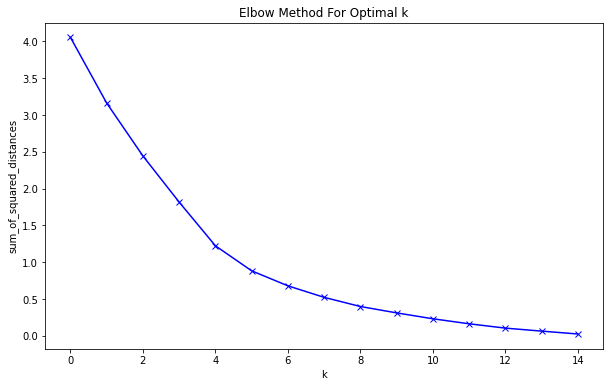

In [127]:
elbow(df_min)

In [128]:
for km in range(2, 17):
  kmeans = KMeans(n_clusters=km, random_state=42, init='random', n_init=100)
  kmeans.fit(df_min)
  print(silhouette_score(df_min, kmeans.labels_))

0.4927811602467577
0.4330421534653613
0.32895150716683613
0.3449407046370379
0.34719106064065364
0.3346069016180943
0.29582861549485
0.23082006840555824
0.17351231675842377
0.16102527891482743
0.10875876738985667
0.08284390816826337
0.0945059783072442
0.057472663451874566
0.04003433878752837


In [129]:
#silhouette 
def silhouette(df):
  sum_of_silhouette = []

  for km in range(2, 17):
    kmeans = KMeans(n_clusters=km, random_state=42, init='random', n_init=100)
    kmeans.fit(df)
    sum_of_silhouette.append(silhouette_score(df, kmeans.labels_))

  plt.figure(figsize=(10, 6))
  plt.plot(sum_of_silhouette, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Score Silhouette')
  plt.title('Silhouette Score For Optimal k');


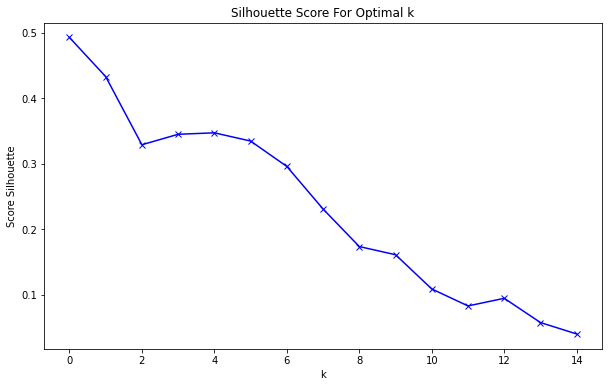

In [130]:
silhouette(df_min)

In [131]:
#cluster ideal (5)

kmeans_ideal = KMeans(n_clusters=5, random_state=42, n_init=100)
kmeans_ideal.fit(df_min)
kmeans_ideal.labels_

array([1, 2, 3, 4, 3, 4, 1, 4, 4, 3, 1, 3, 1, 0, 0, 1, 2], dtype=int32)

In [132]:
df1_ = df1

In [133]:
df1_['Cluster'] = kmeans_ideal.labels_

In [134]:
df1_

,Bairro,Latitude,Longitude,Cluster
0,Botafogo,-22.948845,-43.179829,1
1,Catete,-22.926920,-43.180219,2
2,Copacabana,-22.971964,-43.184343,3
3,Cosme Velho,-22.941514,-43.200624,4
4,Flamengo,-22.933984,-43.174574,3
5,Gávea,-22.981424,-43.238324,4
6,Humaitá,-22.955435,-43.210959,1
7,Ipanema,-22.983956,-43.202216,4
8,Jardim Botânico,-22.968385,-43.228694,4
9,Lagoa,-22.969493,-43.219289,3


In [136]:
# create map cluster
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

cor = {0: 'red', 1:'green', 2: 'black', 3:'orange', 4:'gray', 5:'blue'}
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, bairro, cluster in zip(df1_['Latitude'], df1_['Longitude'], df1_['Bairro'], df1_['Cluster']):
    label = f'{bairro}, {cluster}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[int(cluster-1)],
        color=cor[cluster],
        fill=True,
        fill_color=cor[cluster],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Cluster for Latitude Longitude

In [108]:
df_cluster_lat_long = df1_.drop(['Bairro', 'Cluster'],axis=1)

In [109]:
df_cluster_lat_long = min.fit_transform(df_cluster_lat_long)

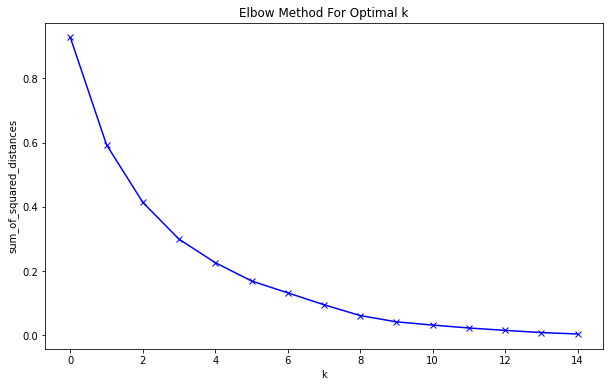

In [110]:
elbow(df_cluster_lat_long)

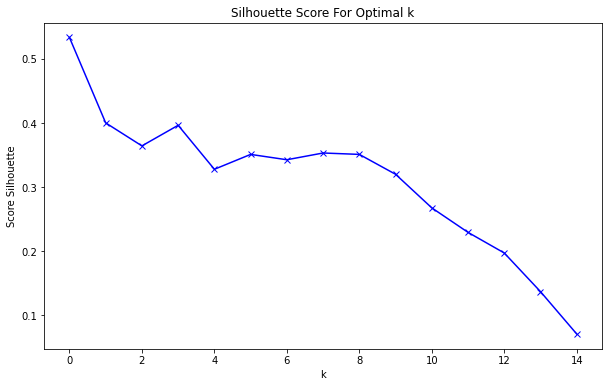

In [111]:
silhouette(df_cluster_lat_long)

In [112]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_cluster_lat_long)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [113]:
df1['Cluster'] = kmeans.labels_

In [114]:
df1

,Bairro,Latitude,Longitude,Cluster
0,Botafogo,-22.948845,-43.179829,2
1,Catete,-22.926920,-43.180219,1
2,Copacabana,-22.971964,-43.184343,2
3,Cosme Velho,-22.941514,-43.200624,1
4,Flamengo,-22.933984,-43.174574,1
5,Gávea,-22.981424,-43.238324,4
6,Humaitá,-22.955435,-43.210959,0
7,Ipanema,-22.983956,-43.202216,4
8,Jardim Botânico,-22.968385,-43.228694,0
9,Lagoa,-22.969493,-43.219289,0


In [115]:
# create map cluster lat / long /cluster=5
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
cor = {0: 'red', 1:'green', 2: 'black', 3:'orange', 4:'gray', 5:'blue'}

# add markers to the map
markers_colors = []
for lat, lon, bairro, cluster in zip(df1['Latitude'], df1['Longitude'], df1['Bairro'], df1['Cluster']):
    label = f'{bairro}, {cluster}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cor[cluster],
        fill=True,
        fill_color=cor[cluster],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters